In [1]:
import math
import pickle
import torch
import torchvision.models as models
import os
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, Birch
import matplotlib.pyplot as plt
from fairis_tools.experiment_tools.place_cell.PlaceCellLibrary import *

os.chdir("../../..")
print(os.getcwd())

/Users/titonka/FAIRIS


In [3]:
# with open("data/VisualPlaceCellData/VisualPlaceCellClusters/cnn_birch_centers",'rb') as file:
#     cluster_centers = pickle.load(file)
with open("data/VisualPlaceCellData/LM8_1000",'rb') as file:
    data = pickle.load(file)

In [4]:
class VisiualPlaceCell:
    def __init__(self, pc_id, center_point, sigma):
        self.id = pc_id
        self.center_point = center_point
        self.sigma = sigma
        self.activity = 0.0

    def calculate_activation(self,robot_point):
        distance = np.linalg.norm(self.center_point - robot_point)
        self.activity = np.exp(-(distance**2) / (2*self.sigma**2))

class VisualPlaceCellNetwork:
    def __init__(self):
        self.pc_network = None
        self.pc_list = []
        self.pc_coordinates = []

    def add_pc_to_network(self, robot_point, radius=.1):
        pc_id = len(self.pc_list)
        self.pc_list.append(VisiualPlaceCell(pc_id, robot_point, radius))
        self.pc_coordinates.append(robot_point)
        self.pc_network = KDTree(self.pc_coordinates)

    def get_num_active_pc(self, robot_point, search_radius=.5):
        if self.pc_network is not None:
            return self.pc_network.query_radius([robot_point], r=search_radius, count_only=True)[0]
        else:
            return 0

    def calculate_single_pc_activation(self, pc, robot_point):
        pc.calculate_activation(robot_point)

    def activate_pc_network(self, robot_point):
        # Standard approach
        for pc in self.pc_list:
            pc.calculate_activation(robot_point)
        self.normilize_all_pc()
    def get_total_pc_activation(self):
        total_activation = 0
        for pc in self.pc_list:
            total_activation += pc.activity
        return total_activation

    def get_all_pc_activations_normalized(self, robot_point):
        self.activate_pc_network(robot_point)
        self.normilize_all_pc()
        return np.array([pc.activity for pc in self.pc_list], dtype=np.float32)

    def print_pc_activations(self):
        for pc in self.pc_list:
            print(pc.id, pc.activity)

    def normilize_all_pc(self):
        total_activation = self.get_total_pc_activation()
        if total_activation == 0:
            total_activation = 1
        for pc in self.pc_list:
            pc.activity = pc.activity / total_activation

In [11]:
# pc_network = VisualPlaceCellNetwork()
# for center in cluster_centers:
#     print(center[1])
#     pc_network.add_pc_to_network(center[0],radius = center[1])
#     

124.47401961680684
252.0800029871828
250.13360636022009
264.41820617483387
206.83574438667097
234.72117379927406
203.78184123449935
256.35670299610507
258.9857113043994
260.6521551872377
232.08895616231612
236.1542725502832
259.66608339256607
275.4338300842016
228.72722846054396
227.3412440427376
213.40185773804095
246.02069390104919


In [6]:
# with open("data/GeneratedPCNetworks/VisualPlaceCells/cnn_birch_pc",'wb') as file:
#     pickle.dump(pc_network,file)

In [7]:
def format_data_for_clustering(data):
    multimodal_feature_vectors = []
    cnn_feature_vectors = []
    xy_list = []
    theta_list = []
    for observation in data.observations:
        multimodal_feature_vectors.append(observation.multimodal_feature_vector)
        cnn_feature_vectors.append(observation.cnn_feature_vector)
        xy_list.append((observation.x, observation.y))
        theta_list.append(observation.theta)

    return multimodal_feature_vectors, cnn_feature_vectors, xy_list, theta_list


In [8]:
with open("data/VisualPlaceCellData/LM8_1000",'rb') as file:
    visual_place_cell_data = pickle.load(file)

multimodal_feature_vectors,cnn_feature_vectors,xy_list,theta_list = format_data_for_clustering(visual_place_cell_data)

In [9]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def plot_place_cell_activity(index):
    """
    Plot the x, y location of the data point and the corresponding place cell activations.
    
    Args:
    - index (int): The index of the selected data point.
    """
    # Get the x, y location of the selected data point
    x, y = xy_list[index]
    dx = 0.45 * np.cos(theta_list[index])
    dy = 0.45 * np.sin(theta_list[index])
    
    
    # Get the place cell activations for the selected data point
    pc_network.activate_pc_network(cnn_feature_vectors[index][0])
    activations = pc_network.get_all_pc_activations_normalized(cnn_feature_vectors[index][0])

    # Create two subplots: one for x, y location and one for place cell activations
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the x, y location on the first subplot
    ax[0].quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='r')
    ax[0].scatter(x, y, color='blue', s=50, zorder=5)
    ax[0].set_xlim(-3.5, 3.5)
    ax[0].set_ylim(-3.5, 3.5)
    ax[0].set_title(f"x, y Location of Data Point {index}")
    ax[0].set_xlabel("X Coordinate")
    ax[0].set_ylabel("Y Coordinate")

    # Plot the place cell activations on the second subplot
    ax[1].bar(range(18), activations, color='red')
    ax[1].set_title(f"Place Cell Activations for Data Point {index}")
    ax[1].set_xlabel("Place Cell")
    ax[1].set_xticks(range(18))
    ax[1].set_xticklabels(range(18)) 
    ax[1].set_ylabel("Activation Level")
    
    # Show the plots
    plt.show()

# Create an interactive slider for selecting the index of the data point
# interact(plot_place_cell_activity, index=IntSlider(min=0, max=999, step=1, value=0))

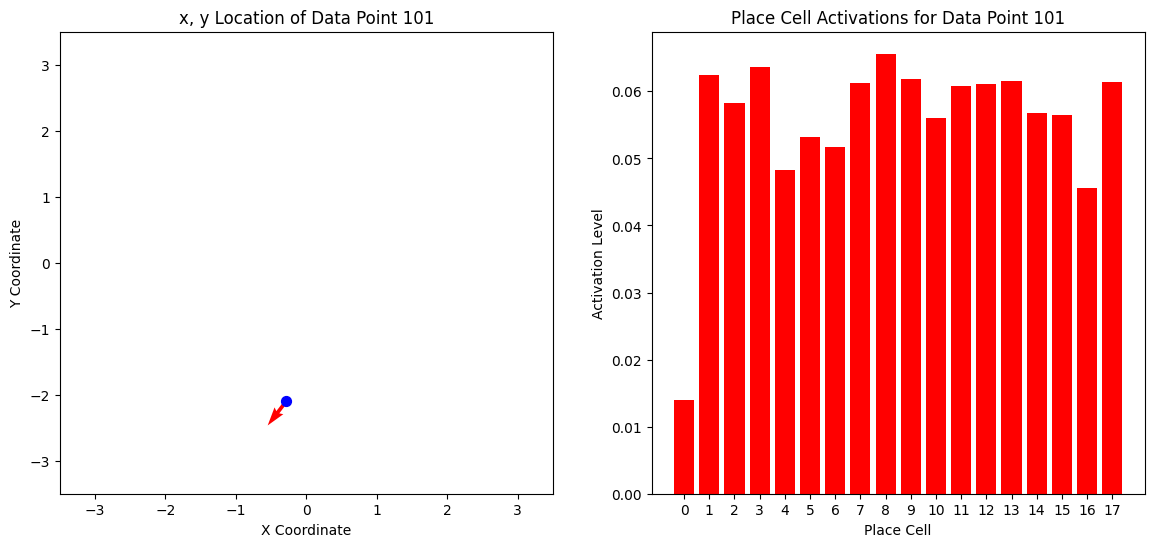

In [10]:
plot_place_cell_activity(101)

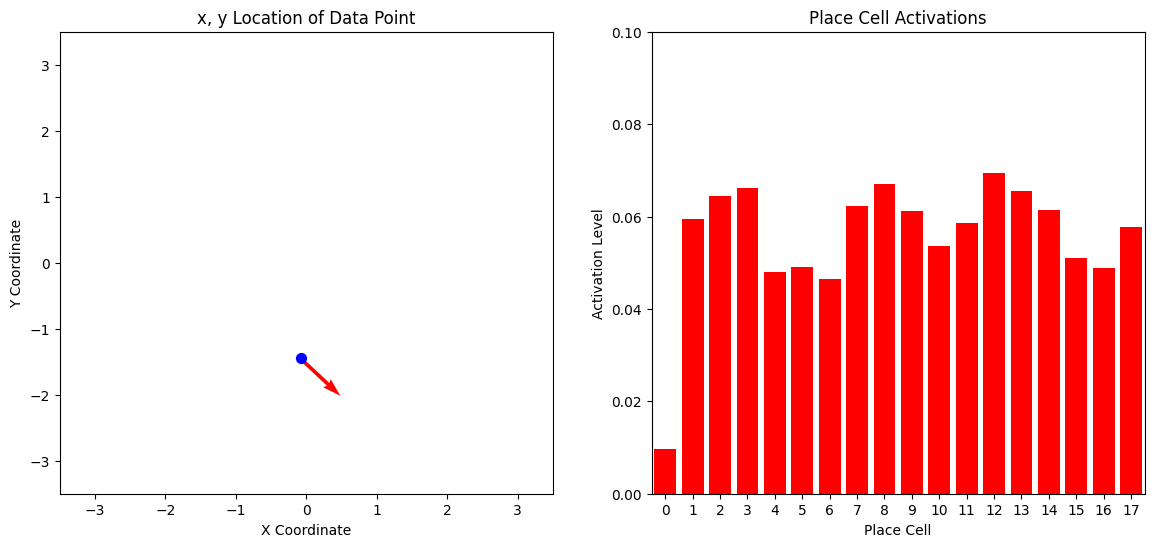

In [13]:
from matplotlib.animation import FuncAnimation

# Assuming pc_network, xy_list, and features are defined elsewhere
n_samples = 100  # Number of data points
n_place_cells = 18  # Number of place cells

# Create the figure and axes for the animation
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Initial plot settings
ax[0].set_xlim(-3.5, 3.5)
ax[0].set_ylim(-3.5, 3.5)
ax[0].set_xlabel("X Coordinate")
ax[0].set_ylabel("Y Coordinate")
ax[0].set_title("x, y Location of Data Point")

ax[1].set_title("Place Cell Activations")
ax[1].set_xlabel("Place Cell")
ax[1].set_xticks(range(n_place_cells))
ax[1].set_xlim(-0.5, n_place_cells - 0.5)  # Adjust x limits to avoid clipping
ax[1].set_ylabel("Activation Level")

# Quiver (vector) and scatter (dot) for the location plot
quiver = ax[0].quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=1, color='r')  # Initialize with 0
dot = ax[0].scatter(0, 0, color='blue', s=50, zorder=5)  # Initialize with 0

# Bar plot for the place cell activations
bars = ax[1].bar(range(n_place_cells), [0] * n_place_cells, color='red')

# Function to initialize the plot (sets up the background for the animation)
def init():
    quiver.set_offsets([0, 0])  # Reset vector position with dummy coordinates
    dot.set_offsets([0, 0])     # Reset dot position with dummy coordinates
    for bar in bars:
        bar.set_height(0)         # Reset the bar heights to 0
    return quiver, dot, *bars

# Function to update the plot for each frame (i.e., for each data point)
def update(frame):
    # Get the x, y location and orientation of the selected data point
    x, y = xy_list[frame]
    theta = math.radians(theta_list[frame])
    dx = 0.8 * np.cos(theta)  # Increase the length of the vector to make it more visible
    dy = 0.8 * np.sin(theta)
    
    # Get the place cell activations for the selected data point
    pc_network.activate_pc_network(cnn_feature_vectors[frame])
    activations = pc_network.get_all_pc_activations_normalized(cnn_feature_vectors[frame])

    # Update the quiver (vector) and scatter (dot) for the x, y location
    quiver.set_offsets([x, y])
    quiver.set_UVC(dx, dy)
    dot.set_offsets([x, y])

    # Update the bar plot for place cell activations
    for bar, activation in zip(bars, activations):
        bar.set_height(activation)

    # Adjust the y-axis limit of the bar plot to be slightly above the maximum activation
    ax[1].set_ylim(0, .1) 

    return quiver, dot, *bars

# Create the animation
ani = FuncAnimation(fig, update, frames=range(n_samples), init_func=init, blit=True, repeat=False)

# Save the animation as a movie (MP4 format)
ani.save("data/videos/place_cell_activity_animation.mp4", writer='ffmpeg', fps=2)


In [1]:
import pickle
import os
import numpy as np
from sklearn.cluster import KMeans, Birch
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import math
os.chdir("../../..")
print(os.getcwd())

with open("data/VisualPlaceCellData/LM8_1000",'rb') as file:
    visual_place_cell_data = pickle.load(file)


n_clusters = [10,20,100,500]  # You can change this based on how many clusters you expect

# Function to plot clusters on the x, y plane
def plot_clusters(xy_list, cluster_labels, name):
    """
    Plot the clusters on the x, y plane using the original (x, y) coordinates, and save the figure.

    Args:
    - xy_list (list of tuples): The original x, y coordinates for each datapoint.
    - cluster_labels (list of int): The cluster label for each datapoint.
    - name (str): The filename to save the figure as (e.g., "clusters_plot.png").
    """
    # Convert xy_list to NumPy arrays for easy plotting
    x_coords = np.array([x for x, y in xy_list])
    y_coords = np.array([y for x, y in xy_list])

    # Check if the lengths match
    if len(x_coords) != len(cluster_labels):
        raise ValueError(f"Mismatch: {len(x_coords)} coordinates and {len(cluster_labels)} cluster labels.")

    # Scatter plot with color coding for clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_coords, y_coords, c=cluster_labels, cmap='rainbow', alpha=0.7)

    # Add color bar to indicate clusters
    plt.colorbar(scatter, label='Cluster')

    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Clustering with {len(set(cluster_labels))} Clusters on X-Y Plane')

    # Save the plot to the specified file
    plt.savefig(name)

    # Close the plot to avoid displaying it when running in scripts
    plt.close()


def plot_clusters_by_subplots(xy_list, theta_list, cluster_labels, name, n_clusters=8):
    """
    Plot the clusters on subplots, one for each cluster, using the original (x, y) coordinates
    and their corresponding direction vectors.

    Args:
    - xy_list (list of tuples): The original x, y coordinates for each datapoint.
    - theta_list (list of floats): The orientation (theta) in degrees for each datapoint.
    - cluster_labels (list of int): The cluster label for each datapoint.
    - name (str): The filename to save the plot.
    - n_clusters (int): Number of clusters to plot.
    """
    # Fixed number of columns
    cols = 5
    # Calculate the number of rows needed
    rows = int(math.ceil(n_clusters / cols))

    # Dynamically scale the figsize based on rows and columns
    width_per_col = 6  # Adjust this for horizontal scaling
    height_per_row = 6  # Adjust this for vertical scaling
    figsize = (cols * width_per_col, rows * height_per_row)

    # Convert xy_list to NumPy arrays for easy filtering and plotting
    x_coords = np.array([x for x, y in xy_list])
    y_coords = np.array([y for x, y in xy_list])
    theta_list = np.array([theta for theta in theta_list])
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for cluster_id in range(n_clusters):
        # Get the indices of the datapoints that belong to the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]

        # Filter x and y coordinates for the current cluster
        cluster_x = x_coords[cluster_indices]
        cluster_y = y_coords[cluster_indices]

        # Extract theta values for the current cluster
        cluster_theta = theta_list[cluster_indices]

        # Compute dx and dy for each point in the current cluster
        cluster_dx = 0.5 * np.cos(np.radians(cluster_theta))
        cluster_dy = 0.5 * np.sin(np.radians(cluster_theta))

        # Scatter plot for the current cluster
        axes[cluster_id].scatter(cluster_x, cluster_y, c=f'C{cluster_id}', alpha=0.7, label='Points')

        # Add quiver plot for vectors
        axes[cluster_id].quiver(cluster_x, cluster_y, cluster_dx, cluster_dy, angles='xy', scale_units='xy', scale=1,
                                color='black', alpha=0.7, label='Vectors')

        # Set subplot title and labels
        axes[cluster_id].set_title(f'Cluster {cluster_id}')
        axes[cluster_id].set_xlabel('X Coordinate')
        axes[cluster_id].set_ylabel('Y Coordinate')
        axes[cluster_id].set_xlim(-3, 3)  # Set x-axis limits
        axes[cluster_id].set_ylim(-3, 3)  # Set y-axis limits
        axes[cluster_id].legend()

    # Hide unused subplots (if n_clusters < len(axes))
    for i in range(n_clusters, len(axes)):
        axes[i].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to the specified file
    fig.savefig(name)
    plt.close()

def format_data_for_clustering(data):
    multimodal_feature_vectors = []
    cnn_feature_vectors = []
    xy_list = []
    theta_list = []
    for observation in data.observations:
        multimodal_feature_vectors.append(observation.multimodal_feature_vector)
        cnn_feature_vectors.append(observation.cnn_feature_vector)
        xy_list.append((observation.x, observation.y))
        theta_list.append(observation.theta)

    return multimodal_feature_vectors, cnn_feature_vectors, xy_list, theta_list

multimodal_feature_vectors,cnn_feature_vectors,xy_list,theta_list = format_data_for_clustering(visual_place_cell_data)
def cluster_with_kmeans_and_save_centers(features_list, n_clusters, centers_save_path):
    """
    Perform KMeans clustering, calculate the maximum distance for each cluster,
    and save the cluster centers and max distances as a list of lists using pickle.

    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to form.
    - centers_save_path (str): Path to save the cluster centers and max distances using pickle.

    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    - cluster_centers (numpy array): The centers of the final clusters.
    """
    features_array = np.array(features_list)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features_array)

    # Get cluster centers and labels for each data point
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # List to store [center, max_distance] for each cluster
    cluster_data = []

    # Calculate max distance for each cluster
    for cluster_index in range(n_clusters):
        # Get data points belonging to this cluster
        cluster_points = features_array[labels == cluster_index]

        # Calculate distances from each point to the cluster center
        distances = cdist(cluster_points, [cluster_centers[cluster_index]], metric='euclidean').flatten()

        # Find the maximum distance for this cluster
        max_distance = distances.max()

        # Append the center and max distance as a pair to cluster_data
        cluster_data.append([cluster_centers[cluster_index].tolist(), max_distance])

    # Save cluster_data (centers and max distances) using pickle
    with open(centers_save_path, 'wb') as f:
        pickle.dump(cluster_data, f)

    return cluster_labels

for n_cluster in n_clusters:

    centers_save_path = "data/VisualPlaceCellData/VisualPlaceCellClusters/multimodal_kmeans_"+str(n_cluster)+"centers"
    cluster_labels = cluster_with_kmeans_and_save_centers(multimodal_feature_vectors, n_cluster, centers_save_path)

    # Now plot the clusters
    plot_clusters_by_subplots(xy_list, theta_list, cluster_labels, "data/figures/Clustering/multimodel_knn_"+str(n_cluster)+"clusters.png", n_clusters=n_cluster)

    centers_save_path = "data/VisualPlaceCellData/VisualPlaceCellClusters/cnn_kmeans_"+str(n_cluster)+"centers"
    cluster_labels = cluster_with_kmeans_and_save_centers(cnn_feature_vectors, n_cluster, centers_save_path)

    # Now plot the clusters
    plot_clusters_by_subplots(xy_list, theta_list, cluster_labels, "data/figures/Clustering/cnn_knn_"+str(n_cluster)+"clusters.png", n_clusters=n_cluster)


/Users/titonka/FAIRIS
